<a href="https://colab.research.google.com/github/pk2971/Air-Quality-vs-Temperature-time-series/blob/main/Customer_Lifetime_Value_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv('RFMScores.csv')

In [13]:
df_user=pd.DataFrame(df.groupby('CustomerID')['Revenue'].sum().reset_index())

In [22]:
df['Revenue'].max()

279489.02

**Since there is no cost specified in the dataset, the Revenue becomes our LTV here in this project.**

In [ ]:
#plot LTV histogram

import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

plot_data = [
    go.Histogram(
        x=df.query('Revenue<20000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

There are some negative and outlier revenue values based off the graph.

**We want to find the correlation between RFM scores and LTV/Revenue**

In [37]:
df_corr=pd.DataFrame()
df_corr['OverallScore']=pd.DataFrame(df['OverallScore'])
df_corr['Revenue']=pd.DataFrame(df['Revenue'])

In [39]:
corr=df_corr['Revenue'].corr(df_corr['OverallScore'])
corr

0.3386547571763006

<Figure size 1440x720 with 0 Axes>

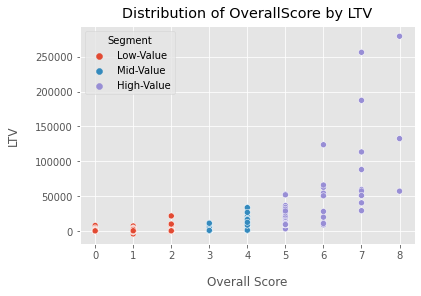

<Figure size 1440x720 with 0 Axes>

In [49]:
sns.scatterplot(x=df['OverallScore'],y=df['Revenue'],hue=df['Segment'])
plt.xlabel("Overall Score", labelpad=15)
plt.ylabel("LTV", labelpad=15)
plt.title("Distribution of OverallScore by LTV", y=1.013);
plt.figure(figsize=(20,10)) 


We can see that high RFM means high LTV. There is a positive correlation here



**We use regression to predict LTV**

We want to segment the LTV as Low LTV, Mid LTV and High LTV. We will once again perform this segmentation using K-Means clustering.

In [53]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[['Revenue']])
df['LTVCluster'] = kmeans.predict(df[['Revenue']])

def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final
df = order_cluster('LTVCluster', 'Revenue',df,True)

In [54]:
df.groupby('LTVCluster')['Revenue'].describe()
#Before removing outliers

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,4339.0,1391.915057,2196.754400,-4287.63,291.475,642.020,1561.0700,25748.35
1,30.0,51237.890000,28724.151854,26626.80,30550.635,45378.135,57319.6375,132572.62
2,3.0,241136.560000,47874.073443,187482.17,221960.330,256438.490,267963.7550,279489.02


**We use the Zscore technique to remove the outliers.**

 We also remove all the negative revenue values in the data set.

In [61]:
df['zscore']=(df.Revenue-df.Revenue.mean())/df.Revenue.std()

In [87]:
df_no_outliers=pd.DataFrame(df[(df.zscore<4) & (df.Revenue>0)])
df_no_outliers.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,LTVCluster,zscore
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value,0,0.412462
1,15808.0,305,0,210,1,3724.77,0,1,Low-Value,0,0.222197
2,13047.0,31,3,196,1,3079.10,0,4,Mid-Value,0,0.143642
3,12583.0,2,3,251,1,7187.34,0,4,Mid-Value,0,0.643467
4,14688.0,7,3,359,1,5107.38,0,4,Mid-Value,0,0.390411


In [88]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_no_outliers[['Revenue']])
df_no_outliers['LTVCluster'] = kmeans.predict(df_no_outliers[['Revenue']])

df_no_outliers = order_cluster('LTVCluster', 'Revenue',df_no_outliers,True)

In [89]:
df_no_outliers .groupby('LTVCluster')['Revenue'].describe()
#After removing ouliers

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,3837.0,826.265075,746.530444,1.776357e-15,270.6000,561.570,1156.36,3228.84
1,424.0,5654.484413,2368.016145,3.245470e+03,3851.5125,4865.935,6746.12,13375.87
2,41.0,21316.093902,6594.070192,1.361207e+04,16173.6700,18793.410,26932.34,33805.69


2 is the best LTV with an average of arounf 21.3k and 0 is the worst LTV with mean of around 746.

**Feature engineering**

We convert some categorical columns to numerical and drop some irrelevant columns.

In [95]:
#dropping irrelevant columns
df_no_outliers =df_no_outliers.drop(['zscore'],axis=1)

In [96]:
df_pred=pd.get_dummies(df_no_outliers)

In [101]:
#Correlation matrix 
corr_matrix = df_pred.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
Revenue               0.831512
RevenueCluster        0.568829
FrequencyCluster      0.552001
Frequency             0.513925
Segment_High-Value    0.486739
OverallScore          0.422320
RecencyCluster        0.228579
Segment_Mid-Value     0.133689
CustomerID           -0.066051
Recency              -0.224399
Segment_Low-Value    -0.266798
Name: LTVCluster, dtype: float64

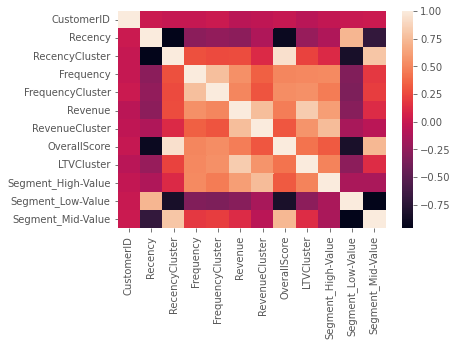

In [100]:
sns.heatmap(corr_matrix)